In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# importing dataset
food_price <- read.csv('../input/global-food-price/wfp_market_food_prices.csv')

In [3]:
# top 6 observations
head(food_price)

In [4]:
food_price <- rename(food_price, country_id = adm0_id)
food_price <- rename(food_price, country = adm0_name)
food_price <- rename(food_price, locality_id = adm1_id)
food_price <- rename(food_price, locality = adm1_name)
food_price <- rename(food_price, market_id = mkt_id)
food_price <- rename(food_price, market = mkt_name)
food_price <- rename(food_price, quantity = um_name)
head(food_price)

In [5]:
nrow(unique(food_price['country']))

In [6]:
unique(food_price['country'])

### Data Cleaning

#### checking for missing / NA values

In [7]:
any(is.na(food_price))

In [8]:
dim(food_price)

In [9]:
sum(any(is.na(food_price)))

*dataset has no null values*

#### removing irrelvant column

In [10]:
food_price <- select(food_price, c(-1,-3, -5, -7, -9, -11, -18))

In [11]:
head(food_price)

In [12]:
library(ggplot2)

In [13]:
# Manipulate the size of the plots
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

### Top 20 highest food observations in the dataset 

In [14]:
fig(20, 8)
ggplot(food_price, aes(x=fct_rev(fct_infreq(cm_name))))+geom_bar(stat='count', width = 0.5) +ggtitle("food frequency")+
scale_x_discrete(expand = c(0, 0.5)) + coord_flip(xlim = c(length(unique(food_price$cm_name))-20, length(unique(food_price$cm_name)))) +
ggtitle("Food frequency") + labs(y="Frequency", x="Food") 

We can see that Maize has the highest frequency followed by millet, sorghum, rice, wheat and sugar.<br>
The reason they have highest frequency because these are the staple foods of world and most of the nation consumes these food and large amounts, hence it is no surprise that the staple foods are the one that has the highest observation frequency in this dataset.
Also Maize is the highest produced food commodity in the world.

https://www.worldatlas.com/articles/most-important-staple-foods-in-the-world.html

### Importing the currency.csv to normalize food price to a common currency (in indian rupees here)

In [15]:
currency <- read.csv('../input/countrycurrency/output.csv')

In [16]:
head(currency)

In [17]:
mean = rowMeans(currency[, 3:10])
new = cbind(currency, mean)
new

### finding the common intersection of countries in both the datasets

In [18]:
curr = unique(food_price['cur_name'])
a = list(new['CURRENCY'][[1]])
b = list(curr['cur_name'][[1]])
count = 0 
common <- intersect(a[[1]], b[[1]])
common
length(common)
setdiff(b[[1]], common)

Only 56 countries are in common in both the countries, so only these countries will be analysed to make the analysis part fair by normalizing the currency to a common currency.

In [19]:
# removing countries that are not common in both the dataset
food_price <- food_price[!(food_price$cur_name == 'MRO' | food_price$cur_name == 'Somaliland Shilling' | food_price$cur_name == 'ZMW' | food_price$cur_name == 'NIS' | food_price$cur_name == 'SSP' ),   ]

In [20]:
# now all the uncommon countires are removed as the set difference is NULL
setdiff(food_price['cur_name'][[1]], common)

In [21]:
# dimension after few country elimination
dim(food_price)

#### Normalizing currency

In [22]:
food_price <- food_price %>% 
    group_by(cur_name) %>%
    mutate(common_price = mp_price / new[new['CURRENCY'] == first(cur_name), c('mean')])

In [23]:
head(food_price)

In [24]:
new[new['CURRENCY'] == "AFN", c('mean')]

In [25]:
unique(food_price$cur_name)

#### cleaning the quantity column name

In [26]:
unique(food_price$quantity)

we can separate quantity and unit using sep = " " (space) in separate function

In [27]:
# cleanign the quantity column
food_price <- food_price %>%
  separate(quantity,c("quantity","unit"), sep = " ", fill = "left")

head(food_price)

In [28]:
food_price$quantity <- as.numeric(food_price$quantity)
unique(food_price$quantity)
unique(food_price$unit)
food_price[is.na(food_price['quantity']), c('quantity')] = 1

In [29]:
head(food_price, 3)

now actual price of commodity = common_price / quantity

In [30]:
food_price <- food_price %>%
        mutate(common_price = common_price / quantity)

#### Converting grams, mililitres, tons to kg, l,and kg respectively  

In [31]:
# grams to kilograms
food_price[food_price['unit'] == 'G', c('common_price')] = food_price[food_price['unit'] == 'G', c('common_price')] * 1000
# millilitre to litre
food_price[food_price['unit'] == 'ML', c('common_price')] = food_price[food_price['unit'] == 'ML', c('common_price')] * 1000
# metric ton to kilograms
food_price[food_price['unit'] == 'MT', c('common_price')] = food_price[food_price['unit'] == 'MT', c('common_price')] / 1000

In [32]:
# write.csv(df,"my_df.csv", row.names = TRUE)

In [33]:
food_price

### Countries with highest observations in the dataset 

In [34]:
fig(20, 45)
ggplot(food_price, aes(x=fct_rev(fct_infreq(country))))+geom_bar(stat='count') +ggtitle("food frequency")+coord_flip()

Suprisingly, Rwanda has the highest number of obeservations inspite of being a third - world among all the developed and underdeveloped countries.<br/>\
But actually there is a reason why rwanda has the highest frequency.
According to this source: https://www.explorerwandatours.com/travel-blog/17-interesting-facts-rwanda.html
1. Rwanda is one of the top five most developed countries since 2000.
2. The country is considered as one of the best country with high internet connectivity in Africa as Rwandan Government is spreading the internet facilities like construction of fiber optic in all parts of country.
3. Rwanda is one of Africa's leading digital revolutions, as every services needed from any public institution for instance tax declaration and payment,Traffic penalties payment and other business registration et cetra are completely done online.
<br><br>
After Rwanda the next highest are India and Niger.<br>
Butan has the lowest observations. The reason is that, butan is not actually a agricultural based courntry due as Bhutan faces water scarcity, fragmented landholding, changing land use etc for agriculture.

### Price in each country given a commodity

#### Tomato

In [35]:
tomato = filter(food_price, cm_name == 'Tomatoes')
tomato_ctry = unique(tomato['country'])
avg_price_list = c()
countrylist = c()
avg_ctry_price_idx = 1
for(ctry in tomato_ctry){
    for(ct in ctry){
        tomato = filter(food_price, cm_name == 'Tomatoes', country == ct)
        yr = c()
        price = c()
        idx = 1
        avg_price = 0
        for (i in unique(tomato['mp_year'])){
            for(j in i){
                c_price = tomato[tomato['mp_year'] == j, ]
                Q <- quantile(c_price$common_price, probs=c(.25, .75), na.rm = FALSE)
                iqr <- IQR(c_price$common_price)
                outlier <- subset(c_price, c_price$common_price < (Q[1] - 1.5*iqr) | c_price$common_price > (Q[2]+1.5*iqr))
                non_outlier <- subset(c_price, c_price$common_price >= (Q[1] - 1.5*iqr) & c_price$common_price <= (Q[2]+1.5*iqr))
                c_price[which(c_price$common_price %in% outlier$common_price), 'common_price'] = mean(non_outlier$common_price, na.rm = TRUE)
                year = c_price[ ,'common_price']
                count = length(year)
                avg = sum(year)/count
                avg_price = avg_price + sum(year)
                yr[idx] = j
                price[idx] = avg
                idx = idx + 1
            }
            avg_price_list[avg_ctry_price_idx] = round((avg_price / nrow(tomato['mp_year'])), digits = 0)
        }
        countrylist[avg_ctry_price_idx] = ct
        avg_ctry_price_idx = avg_ctry_price_idx + 1
    }
}

In [36]:
fig(15, 8)
tomato_commodity_price = data.frame(countrylist, avg_price_list) 
#fig(25, 8)
print(ggplot(tomato_commodity_price, aes(x=reorder(countrylist, avg_price_list),y =avg_price_list, fill = countrylist)) + 
        geom_bar(stat="identity", width=0.5) + ggtitle("Global tomato price") + labs(y="cost price", x="food") +
    geom_text(aes(label=avg_price_list), position=position_dodge(width=0.9), vjust=-0.25))

We can see that Egypt and India both sells the tomato at least price. Arabia and most middle east countries have high tomato as the these places are dry arid deserts and is not fit for agriculture 

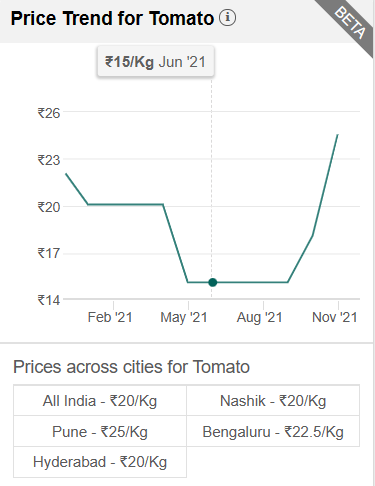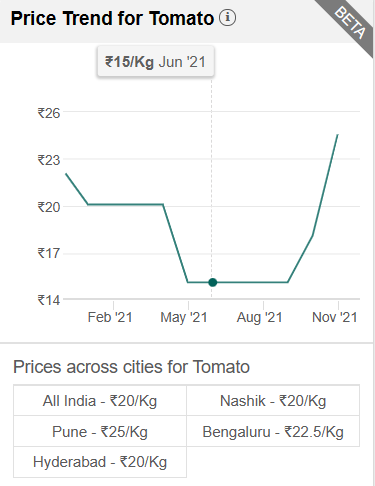

### Global prices of some staples food in each country 

#### Maize

In [37]:
maize = filter(food_price, cm_name == 'Maize')
maize_ctry = unique(maize['country'])
avg_price_list = c()
countrylist = c()
avg_ctry_price_idx = 1
for(ctry in maize_ctry){
    for(ct in ctry){
        maize = filter(food_price, cm_name == 'Maize', country == ct)
        yr = c()
        price = c()
        idx = 1
        avg_price = 0
        for (i in unique(maize['mp_year'])){
            for(j in i){
                c_price = maize[maize['mp_year'] == j, ]
                o <- boxplot.stats(c_price$common_price)$out
                Q <- quantile(c_price$common_price, probs=c(.25, .75), na.rm = FALSE)
                iqr <- IQR(c_price$common_price)
                non_outlier <- subset(c_price, c_price$common_price >= (Q[1] - 1.5*iqr) & c_price$common_price <= (Q[2]+1.5*iqr))
                c_price[which(c_price$common_price %in% o), 'common_price'] = mean(non_outlier$common_price, na.rm = TRUE)
                year = c_price[ ,'common_price']
                count = length(year)
                avg = sum(year)/count
                avg_price = avg_price + sum(year)
                yr[idx] = j
                price[idx] = avg
                idx = idx + 1
            }
            avg_price_list[avg_ctry_price_idx] = round((avg_price / nrow(maize['mp_year'])), digits = 0)
        }
        countrylist[avg_ctry_price_idx] = ct
        avg_ctry_price_idx = avg_ctry_price_idx + 1
    }
}

In [38]:
fig(30, 10)
maize_commodity_price = data.frame(countrylist, avg_price_list) 
print(ggplot(maize_commodity_price, aes(x=reorder(countrylist, avg_price_list),y =avg_price_list, fill = countrylist)) + 
        geom_bar(stat="identity", width=0.5) + ggtitle("Global Maize price") + labs(y="cost price", x="food") +
    geom_text(aes(label=avg_price_list), position=position_dodge(width=0.9), vjust=-0.25))

#### Rice

In [39]:
rice = filter(food_price, cm_name == 'Rice')
rice_ctry = unique(rice['country'])
avg_price_list = c()
countrylist = c()
avg_ctry_price_idx = 1
for(ctry in rice_ctry){
    for(ct in ctry){
        rice = filter(food_price, cm_name == 'Rice', country == ct)
        yr = c()
        price = c()
        idx = 1
        avg_price = 0
        for (i in unique(rice['mp_year'])){
            for(j in i){
                c_price = rice[rice['mp_year'] == j, ]
                o <- boxplot.stats(c_price$common_price)$out
                Q <- quantile(c_price$common_price, probs=c(.25, .75), na.rm = FALSE)
                iqr <- IQR(c_price$common_price)
                non_outlier <- subset(c_price, c_price$common_price >= (Q[1] - 1.5*iqr) & c_price$common_price <= (Q[2]+1.5*iqr))
                c_price[which(c_price$common_price %in% o), 'common_price'] = mean(non_outlier$common_price, na.rm = TRUE)
                year = c_price[ ,'common_price']
                count = length(year)
                avg = sum(year)/count
                avg_price = avg_price + sum(year)
                yr[idx] = j
                price[idx] = avg
                idx = idx + 1
            }
            avg_price_list[avg_ctry_price_idx] = round((avg_price / nrow(rice['mp_year'])), digits = 0)
        }
        countrylist[avg_ctry_price_idx] = ct
        avg_ctry_price_idx = avg_ctry_price_idx + 1
    }
}

In [40]:
fig(30, 10)
rice_commodity_price = data.frame(countrylist, avg_price_list) 
print(ggplot(rice_commodity_price, aes(x=reorder(countrylist, avg_price_list),y =avg_price_list, fill = countrylist)) + 
        geom_bar(stat="identity", width=0.5) + ggtitle("Global Rice price") + labs(y="cost price", x="country") +
    geom_text(aes(label=avg_price_list), position=position_dodge(width=0.9), vjust=-0.25))

Nepal followed by india has the lowest rice price. Again middle east countries like iraq, syria and turkey top the list for highest rice price.

#### Wheat

In [41]:
wheat = filter(food_price, cm_name == 'Wheat')
wheat_ctry = unique(wheat['country'])
avg_price_list = c()
countrylist = c()
avg_ctry_price_idx = 1
for(ctry in wheat_ctry){
    for(ct in ctry){
        wheat = filter(food_price, cm_name == 'Wheat', country == ct)
        yr = c()
        price = c()
        idx = 1
        avg_price = 0
        for (i in unique(wheat['mp_year'])){
            for(j in i){
                c_price = wheat[wheat['mp_year'] == j, ]
                o <- boxplot.stats(c_price$common_price)$out
                Q <- quantile(c_price$common_price, probs=c(.25, .75), na.rm = FALSE)
                iqr <- IQR(c_price$common_price)
                non_outlier <- subset(c_price, c_price$common_price >= (Q[1] - 1.5*iqr) & c_price$common_price <= (Q[2]+1.5*iqr))
                c_price[which(c_price$common_price %in% o), 'common_price'] = mean(non_outlier$common_price, na.rm = TRUE)
                year = c_price[ ,'common_price']
                count = length(year)
                avg = sum(year)/count
                avg_price = avg_price + sum(year)
                yr[idx] = j
                price[idx] = avg
                idx = idx + 1
            }
            avg_price_list[avg_ctry_price_idx] = round((avg_price / nrow(wheat['mp_year'])), digits = 0)
        }
        countrylist[avg_ctry_price_idx] = ct
        avg_ctry_price_idx = avg_ctry_price_idx + 1
    }
}


In [42]:
fig(30, 10)
wheat_commodity_price = data.frame(countrylist, avg_price_list) 
print(ggplot(wheat_commodity_price, aes(x=reorder(countrylist, avg_price_list),y =avg_price_list, fill = countrylist)) + 
        geom_bar(stat="identity", width=0.5) + ggtitle("Global Wheat price") + labs(y="cost price", x="country") +
    geom_text(aes(label=avg_price_list), position=position_dodge(width=0.9), vjust=-0.25))

Sudan again followed by India has the lowest rice price. Nigeria has the higest food price

### Did you notice?

India has one of the lowest price for both and rice and wheat. Its because rice and wheat is the staple food of India and India is the largest prouducer and consumer of rice and wheat among all developing and under-developing countries.

### Is the global food prices increasing yearly?

*conducting this experiment on top countries in this dataset*

### yearly trends of some food commodities in India 

In [43]:
foods = c('Rice', 'Wheat','Sugar','Salt (iodised)', 'Lentils', 'Milk (pasteurized)', 'Tomatoes')
for (food in foods){
fd = filter(food_price, cm_name == food, country == 'India')
yr = c()
price = c()
idx = 1
avg_price = 0
for (i in unique(fd['mp_year'])){
    for(j in i){
        if(j != 2017){
        c_price = fd[fd['mp_year'] == j, ]
        o <- boxplot.stats(c_price$common_price)$out
        Q <- quantile(c_price$common_price, probs=c(.25, .75), na.rm = FALSE)
        iqr <- IQR(c_price$common_price)
        non_outlier <- subset(c_price, c_price$common_price >= (Q[1] - 1.5*iqr) & c_price$common_price <= (Q[2]+1.5*iqr))
        c_price[which(c_price$common_price %in% o), 'common_price'] = mean(non_outlier$common_price, na.rm = TRUE)
        year = c_price[ ,'common_price']
        count = nrow(year)
        avg = sum(year)/count
        yr[idx] = j
        price[idx] = avg
        idx = idx + 1
        }
    }
}
fig(5, 5)
print(ggplot() + geom_line(aes(x = yr, y = price)) + geom_point(aes(x = yr, y = price)) + labs(title = paste('India\'s', food, 'price') ,y='price', x = 'year'))
}

we can see that in most of the cases there has been a steady increases in  food prices in India yearly

### yearly trends of some food commodities in Rwanda

In [44]:
foods = c('Wheat flour', 'Rice', 'Milk','Eggs','Beans (dry)')
for (food in foods){
fd = filter(food_price, cm_name == food, country == 'Rwanda')
yr = c()
price = c()
idx = 1
avg_price = 0
for (i in unique(fd['mp_year'])){
    for(j in i){
        if(j != 2017){
        c_price = fd[fd['mp_year'] == j, ]
        o <- boxplot.stats(c_price$common_price)$out
        Q <- quantile(c_price$common_price, probs=c(.25, .75), na.rm = FALSE)
        iqr <- IQR(c_price$common_price)
        non_outlier <- subset(c_price, c_price$common_price >= (Q[1] - 1.5*iqr) & c_price$common_price <= (Q[2]+1.5*iqr))
        c_price[which(c_price$common_price %in% o), 'common_price'] = mean(non_outlier$common_price, na.rm = TRUE)
        year = c_price[ ,'common_price']
        count = nrow(year)
        avg = sum(year)/count
        yr[idx] = j
        price[idx] = avg
        idx = idx + 1
        }
    }
}
fig(5, 5)
print(ggplot() + geom_line(aes(x = yr, y = price)) + geom_point(aes(x = yr, y = price)) + labs(title = paste('Rwanda\'s', food, 'price') ,y='price', x = 'year'))
}

we can again see that in most of the cases there has been a steady increases in  food prices in India yearly

### Yearly Trend of food prices in Niger

In [45]:
foods = c('Maize','Millet','Beans (niebe)', 'Sorghum')
for (food in foods){
fd = filter(food_price, cm_name == food, country == 'Niger')
yr = c()
price = c()
idx = 1
avg_price = 0
for (i in unique(fd['mp_year'])){
    for(j in i){
        if(j != 2017){
        c_price = fd[fd['mp_year'] == j, ]
        o <- boxplot.stats(c_price$common_price)$out
        Q <- quantile(c_price$common_price, probs=c(.25, .75), na.rm = FALSE)
        iqr <- IQR(c_price$common_price)
        non_outlier <- subset(c_price, c_price$common_price >= (Q[1] - 1.5*iqr) & c_price$common_price <= (Q[2]+1.5*iqr))
        c_price[which(c_price$common_price %in% o), 'common_price'] = mean(non_outlier$common_price, na.rm = TRUE)
        year = c_price[ ,'common_price']
        count = nrow(year)
        avg = sum(year)/count
        yr[idx] = j
        price[idx] = avg
        idx = idx + 1
        }
    }
}
fig(5, 5)
print(ggplot() + geom_line(aes(x = yr, y = price)) + geom_point(aes(x = yr, y = price)) + labs(title = paste('Niger\'s', food, 'price') ,y='price', x = 'year'))
}

Even though we can see an up and down fluctions food price in nigeria, but still on a whole the graph seems to be an upwardly increasing graph 

**Conclusion**: From our study in the yearly trends of some countries we have seen that there has been an upward trend in the yearly global food prices.<br>
Hence, it can be generalized that with increase in years, the price of food prices in the global market also increases. <br>
our finding is also supported by this article: https://money.yahoo.com/food-prices-are-going-up-three-times-152157829.html. <br>
Accoding to this article, it blames the the food supply chain breakdown and labor market shortage. To retain workforces, food manufacturers and producers are paying higher wages and shoppers are footing the bill in the form of heftier prices.

### Relationship between oil(organic) price and grain price

The relationship between the oil price and grain price is found to be proprotional according the this paper: https://www.sciencedirect.com/science/article/abs/pii/S0306261910000516.

**Reason:**<br>
The empirical results show that the changes in each oil
price is significantly influenced by the changes in the grain prices, as vegetable oil is made from dried grains. So trend goes like, if the grain price increases so should be the oil price  

In [46]:
foods = c('Rice','Wheat', 'Maize', 'Oil (vegetable)')
pricelist = c()
pidx = 1
for (food in foods){
oil = filter(food_price, cm_name == food, country == 'Tajikistan')
yr = c()
price = c()
idx = 1
avg_price = 0
myplot = ggplot()
for (i in unique(oil['mp_year'])){
    for(j in i){
        if(j != 2017){
        c_price = oil[oil['mp_year'] == j, ]
        o <- boxplot.stats(c_price$common_price)$out
        Q <- quantile(c_price$common_price, probs=c(.25, .75), na.rm = FALSE)
        iqr <- IQR(c_price$common_price)
        non_outlier <- subset(c_price, c_price$common_price >= (Q[1] - 1.5*iqr) & c_price$common_price <= (Q[2]+1.5*iqr))
        c_price[which(c_price$common_price %in% o), 'common_price'] = mean(non_outlier$common_price, na.rm = TRUE)
        year = c_price['common_price']
        count = nrow(year)
        avg = sum(year)/count
        yr[idx] = j
        price[idx] = avg
        idx = idx + 1
        }
    }
}
pricelist[pidx] = list(price)
    pidx = pidx + 1
}
p = c(pricelist[1])
fig(30, 10)
print(ggplot() + geom_line(aes(x = yr, y = pricelist[[1]], color = 'rice')) + geom_point(aes(x = yr, y = pricelist[[1]])) + 
                geom_line(aes(x = yr, y = pricelist[[2]], color='wheat')) + geom_point(aes(x = yr, y = pricelist[[2]])) +
      geom_line(aes(x = yr, y = pricelist[[3]], color='maize')) + geom_point(aes(x = yr, y = pricelist[[3]]))+
      geom_line(aes(x = yr, y = pricelist[[4]], color='oil')) + geom_point(aes(x = yr, y = pricelist[[4]]))
      + ggtitle("Oil vs grain price") + labs(y="cost pice", x="year"))

### Costliest commodity in India

Filtering out only india from all countries

In [47]:
india = filter(food_price, country == 'India')
india_ctry = unique(india['cm_name'])

Finding out the average price of all the commodites produced by India

In [48]:
india = filter(food_price, country == 'India')
india_ctry = unique(india['cm_name'])
avg_price_list = c()
foodlist = c()
avg_ctry_price_idx = 1
for(foods in india_ctry){
    for(food in foods){
        fd = filter(food_price, cm_name == food)
        yr = c()
        price = c()
        idx = 1
        avg_price = 0
        for (i in unique(fd['mp_year'])){
            for(j in i){
                c_price = fd[fd['mp_year'] == j, ]
                o <- boxplot.stats(c_price$common_price)$out
                Q <- quantile(c_price$common_price, probs=c(.25, .75), na.rm = FALSE)
                iqr <- IQR(c_price$common_price)
                non_outlier <- subset(c_price, c_price$common_price >= (Q[1] - 1.5*iqr) & c_price$common_price <= (Q[2]+1.5*iqr))
                c_price[which(c_price$common_price %in% o), 'common_price'] = mean(non_outlier$common_price, na.rm = TRUE)
                year = c_price[ ,'common_price']
                count = length(year)
                avg = sum(year)/count
                avg_price = avg_price + sum(year)
                yr[idx] = j
                price[idx] = avg
                idx = idx + 1
            }
            avg_price_list[avg_ctry_price_idx] = round((avg_price / nrow(fd['mp_year'])), digits = 0)
        }
        foodlist[avg_ctry_price_idx] = food
        avg_ctry_price_idx = avg_ctry_price_idx + 1
    }
}


Plotting the food vs price of India produced commodities

In [49]:
india_commodity_price = data.frame(foodlist,  avg_price_list) 
fig(25, 8)
ggplot(india_commodity_price, aes(x=reorder(foodlist, avg_price_list),y =avg_price_list, fill = foodlist)) + 
        geom_bar(stat="identity", width=0.5) + ggtitle("Food price of India") + labs(y="cost price", x="food") +
    geom_text(aes(label=avg_price_list), position=position_dodge(width=0.9), vjust=-0.25)


The cost of Tea(black) is highest with a cost price of rs 168. We can see mostly the different types oils and lentils have the highest cost price.
The salt has the lowest price of just rs 18. 

### 